# **Associations between aversive learning processes and transdiagnostic psychiatric symptoms revealed by large-scale phenotyping**

---

# Data preprocessing

This notebook takes the raw behavioural data and preprocesses it. This turns the data from a high-frequency position recording to a single pre=emptive position for each trial.

> **_Note:_**    This is a template notebook. This is parameterised and run for each subject using [Papermill](https://papermill.readthedocs.io/en/latest/). Example data is shown here for illustration of how the notebook works.

### Imports

In [14]:
import matplotlib as mpl
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Nice colours
pal = ['#4f4f4f', '#B80044', '#0e79b2']

## Parameters

These are default parameters that can be replaced each time the notebook is run.

In [10]:
# Parameters
behaviour_file = ""
behaviour_path = "../Data"
last_sample = 5  # Last sample in the "trial" to use for behavioural measure
first_sample = 3  # First sample to use

Function used to select samples within each trial

In [5]:
def select_samples(df):
    return df.iloc[first_sample:last_sample]

## Load data and get subject ID

In [11]:
# Get subject ID
sub = re.search('(?<=_).+(?=_)', behaviour_file).group()
print "Processing subject {0}".format(sub)

# Load json
df = pd.read_csv(os.path.join(behaviour_path, behaviour_file))

Processing subject data_5c096a7ceea8950001021e9d


## Clean up the data

Remove the first trial as it's going to be noisy and has weird "undefined" values in the data. Convert things to the right data type and set non-existent hole positions (given as -999 by the game) to nan.

In [12]:
df.columns = [i.replace(' ', '') for i in df.columns]  # remove random spaces in column names
df = df[df.trial > 0]  # remove the first trial
df.hole1_y = df.hole1_y.astype(int)
df.hole2_y = df.hole2_y.astype(int)
df.score = df.score.astype(int)
df.trial = df.trial.astype(int)
df.health = df.health.astype(float)
df.loc[df.hole1_y < 0, 'hole1_y'] = np.nan
df.loc[df.hole2_y < 0, 'hole2_y'] = np.nan


## Separate game phases

First phase represents the learning game, second phase represents the avoidance test which is designed to measure non-learning related avoidance ability.

In [13]:
avoidance = df[df.trial_type == ' avoidance'].copy().reset_index()
df = df[df.trial_type != ' avoidance']
avoidance.head()

,index,health,hole1_y,hole2_y,player_y,score,subjectID,trial,trial_type
0,2192,0.9018,0.0,0.0,133.959227,500,5c096a7ceea8950001021e9d,1,avoidance
1,2193,0.9048,0.0,0.0,130.981075,550,5c096a7ceea8950001021e9d,1,avoidance
2,2194,0.9078,0.0,0.0,190.328025,600,5c096a7ceea8950001021e9d,1,avoidance
3,2195,0.9104,0.0,0.0,222.872612,650,5c096a7ceea8950001021e9d,1,avoidance
4,2196,0.9132,0.0,0.0,222.188502,700,5c096a7ceea8950001021e9d,1,avoidance


## Plot the full data

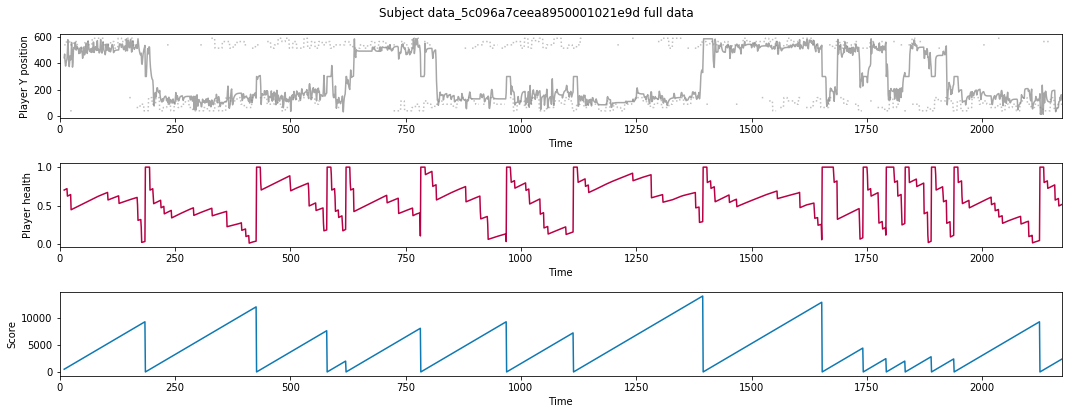

In [15]:
fig, ax = plt.subplots(3, figsize=(15, 6))
ax[0].plot(600 - df.player_y, color=pal[0], alpha=0.5)
ax[0].set_ylabel('Player Y position')
ax[0].set_xlabel("Time")
ax[0].set_xlim(0, len(df))

ax[0].plot(600 - (df.hole1_y * 25 + 10), linestyle=':', color='gray', alpha=0.5)
ax[0].plot(600 - (df.hole2_y * 25 + 10), linestyle=':', color='gray', alpha=0.5)

if 'health' in df.columns:
    ax[1].plot(df.health, color=pal[1])
    ax[1].set_ylabel('Player health')
    ax[1].set_xlabel("Time")
    ax[1].set_xlim(0, len(df))

if 'score' in df.columns:
    ax[2].plot(df.score, color=pal[2])
    ax[2].set_ylabel('Score')
    ax[2].set_xlabel("Time")
    ax[2].set_xlim(0, len(df))

fig.suptitle("Subject {0} full data".format(sub))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Create summary data

Here we select the samples of interest from each trial and plot this data.

In [16]:
summary_df = df[['trial', 'hole1_y', 'hole2_y','player_y', 'health', 'score']].copy()
summary_df = summary_df.groupby('trial', group_keys=False).apply(select_samples)
summary_df = summary_df.groupby('trial').mean().reset_index()

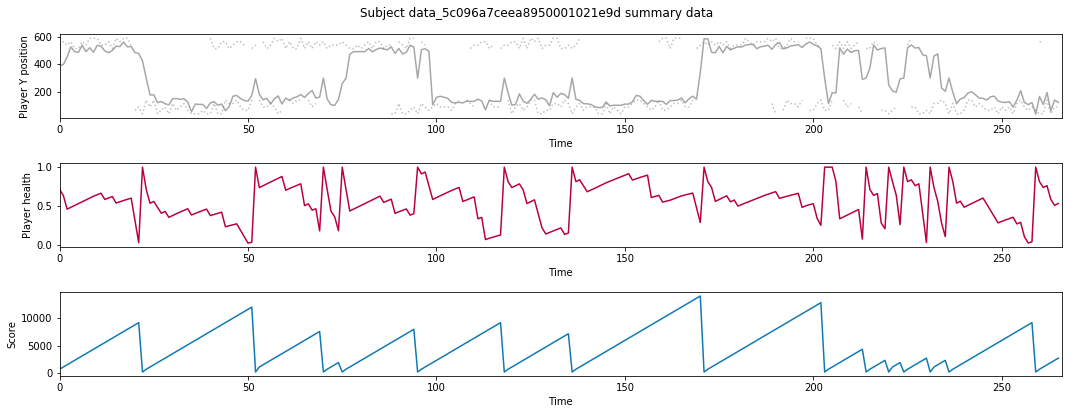

In [17]:
fig, ax = plt.subplots(3, figsize=(15, 6))
ax[0].plot(600 - summary_df.player_y, color=pal[0], alpha=0.5)
ax[0].set_ylabel('Player Y position')
ax[0].set_xlabel("Time")
ax[0].set_xlim(0, len(summary_df))

ax[0].plot(600 - (summary_df.hole1_y * 25 + 10), linestyle=':', color='gray', alpha=0.5)
ax[0].plot(600 - (summary_df.hole2_y * 25 + 10), linestyle=':', color='gray', alpha=0.5)

if 'health' in df.columns:
    ax[1].plot(summary_df.health, color=pal[1])
    ax[1].set_ylabel('Player health')
    ax[1].set_xlabel("Time")
    ax[1].set_xlim(0, len(summary_df))

if 'score' in df.columns:
    ax[2].plot(summary_df.score, color=pal[2])
    ax[2].set_ylabel('Score')
    ax[2].set_xlabel("Time")
    ax[2].set_xlim(0, len(summary_df))

fig.suptitle("Subject {0} summary data".format(sub))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Create modelling data

This puts the data into the format expected by DMpy and removes any odd trials at the end so we end up with 269 trials.

In [18]:
modelling_data = summary_df[['player_y', 'hole1_y', 'hole2_y', 'health', 'score', 'trial']].copy()[0:]
modelling_data.columns = ['Response', 'Outcome', 'Outcome_2', 'health', 'score', 'trial']
modelling_data.Response /= 600
modelling_data.Response = 1 - modelling_data.Response
modelling_data.Outcome = (~np.isnan(modelling_data.Outcome)).astype(int)
modelling_data.Outcome_2 = (~np.isnan(modelling_data.Outcome_2)).astype(int)
modelling_data['Subject'] = sub

for i in range(1, 270):
    if not i in modelling_data['trial'].values:
        modelling_data = modelling_data.append(pd.DataFrame({'Response': [np.nan], 'Outcome': [-1], 
                                                             'Outcome_2': [-1], 'health': [np.nan], 'score': [np.nan],
                                                             'Subject': [modelling_data['Subject'].values[0]], 'trial': i})).reset_index(drop=True).sort_values('trial')


print "Number of trials = {0}".format(len(modelling_data))

Number of trials = 269


C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


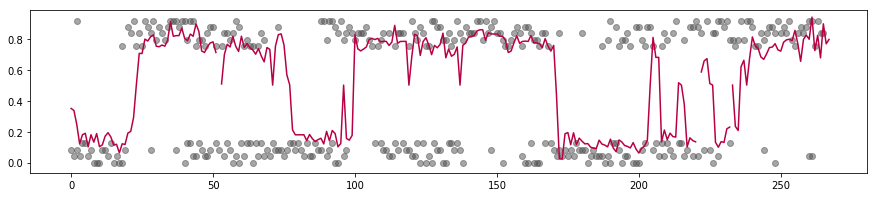

In [22]:
plt.figure(figsize=(15, 3))
plt.plot(1 - modelling_data['Response'], color=pal[1])
plt.scatter(range(len(summary_df)), summary_df['hole1_y'] / 24, color=pal[0], alpha=0.5)
plt.scatter(range(len(summary_df)), summary_df['hole2_y'] / 24, color=pal[0], alpha=0.5)

## Save data

In [ ]:
if len(modelling_data) == 269:
    modelling_data.to_csv(os.path.join('Data/', 'modelling_data/{0}.csv'.format(sub)))

## Extract mean spaceship health from avoidance test

In [49]:
avoidance.head()

,index,health,hole1_y,hole2_y,player_y,score,subjectID,trial,trial_type
0,2222,1.0,0.0,0.0,300.000000,50,5bfe49a6aa5fa30001369012,271,avoidance
1,2223,1.0,0.0,0.0,300.000000,100,5bfe49a6aa5fa30001369012,271,avoidance
2,2224,1.0,0.0,0.0,300.000000,150,5bfe49a6aa5fa30001369012,271,avoidance
3,2225,1.0,0.0,0.0,258.109703,200,5bfe49a6aa5fa30001369012,271,avoidance
4,2226,1.0,0.0,0.0,203.517959,250,5bfe49a6aa5fa30001369012,271,avoidance


In [ ]:
mean_health = np.nanmean(avoidance.health)
print "Mean health = {0}".format(mean_health)

In [ ]:
if len(modelling_data) > 250:
    print "Subject = {0}".format(avoidance['subjectID'][0])
    with open (os.path.join(behaviour_path, 'avoidance_test_scores.txt'),'a') as f:
        f.write(avoidance['subjectID'][0] + ',' + str(mean_health) + '\n')